# Import

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go
import copy 

import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector 

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from sklearn import svm
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.abod import ABOD
from alibi_detect.od import IForest
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.lscp import LSCP
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from sklearn.svm import OneClassSVM

# Purpose of Post - ROC/AUC

Text(0.5, 0, 'FPR')

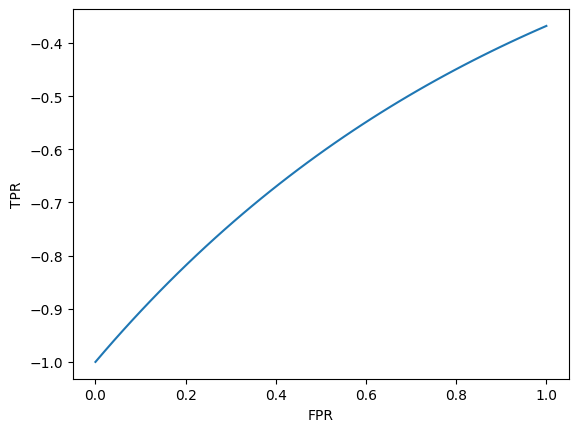

In [245]:
_x = np.linspace(0,1)
_y = np.exp(-_x) * -1
plt.plot(_x,_y)
plt.ylabel('TPR')
plt.xlabel('FPR')

x 축 (FPR) =  FP / (FP + TN)

y 축 (TPR) =  TP / (TP + FN)

로 만들어진 곡선이 ROC 곡선, 그 아래 면적이 AUC, 

# Class

In [2]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
    def conf(self,name):
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)

In [3]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,threshold=0,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>threshold,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [4]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,threshold=0,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>threshold,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [5]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,threshold=0,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>threshold,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

# Linear

In [171]:
np.random.seed(6)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon
outlier_true_one_1 = signal.copy()
outlier_true_one_1 = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one_1))

In [172]:
x_1 = np.linspace(0,2,1000)
y1_1 = 5 * x_1
y_1 = y1_1 + eta # eta = signal + epsilon
_df=pd.DataFrame({'x':x_1, 'y':y_1})

In [173]:
w=np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

## GODE_Linear

In [179]:
_Linear = Linear(_df)
_Linear.fit(threshold=0,sd=20)

**피리오도그램을 구하고 thresholding을 조정하며 auc 구한다면, 피리오도그램 값이 아래와 같이 나와 thresholding을 하는 것이 의미가 있는지 하는 의문..**

In [192]:
pd.unique(_Linear.power_threshed)

array([24952.33637726,  8400.08080592,     0.        ,   127.44794327])

In [193]:
_Linear.power_threshed[:5]

array([24952.33637726,  8400.08080592,     0.        ,   127.44794327,
           0.        ])

In [254]:
np.sort(_Linear.power_threshed)[-5:]

array([    0.        ,     0.        ,   127.44794327,  8400.08080592,
       24952.33637726])

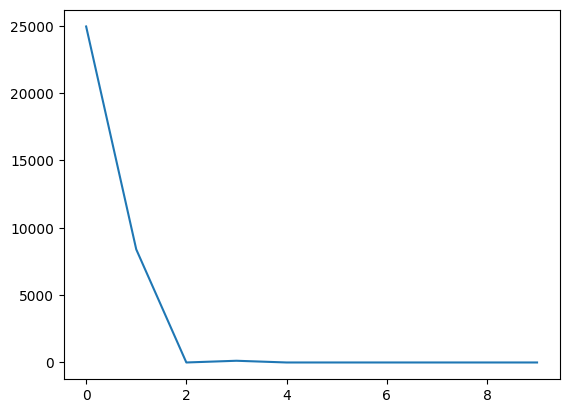

In [190]:
plt.plot(_Linear.power_threshed[0:10])

In [175]:
outlier_simul_one = (_Linear.df['Residual']**2).tolist()
sorted_data = sorted(outlier_simul_one,reverse=True)
index = int(len(sorted_data) * 0.05)
threshold = sorted_data[index]
outlier_simul_one = list(map(lambda x: -1 if x > threshold else 1,outlier_simul_one))

In [176]:
outlier_simul_one.count(1)

950

In [177]:
outlier_simul_one.count(-1)

50

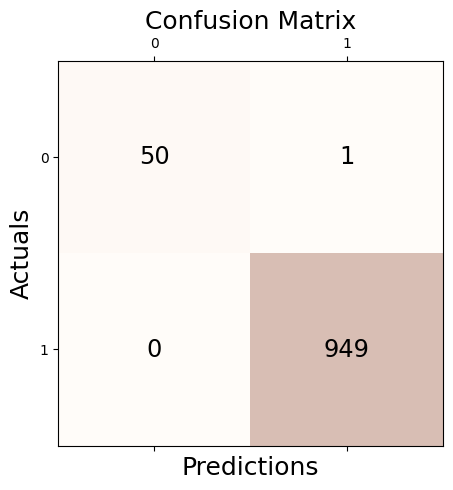

Accuracy: 0.999
Precision: 0.999
Recall: 1.000
F1 Score: 0.999


In [178]:
_conf = Conf_matrx(outlier_true_one_1,outlier_simul_one)
_conf.conf("GODE")

In [169]:
_conf.conf_matrix[0][1] / (_conf.conf_matrix[0][1] + _conf.conf_matrix[0][0])

0.0196078431372549

y축(TPR)

In [170]:
_conf.conf_matrix[1][1] / (_conf.conf_matrix[1][1] + _conf.conf_matrix[0][0])

0.94994994994995

## LOF_Linear

In [135]:
np.random.seed(77)
clf = LocalOutlierFactor(contamination=0.05)

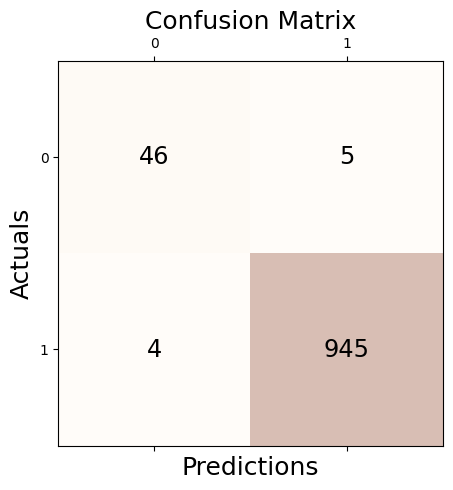

Accuracy: 0.991
Precision: 0.995
Recall: 0.996
F1 Score: 0.995


In [136]:
_conf = Conf_matrx(outlier_true_one_1,clf.fit_predict(_df))
_conf.conf("LOF (Breunig et al., 2000)")

x축(FPR)

In [137]:
_conf.conf_matrix[0][0] / (_conf.conf_matrix[0][0] + _conf.conf_matrix[0][1])

0.9019607843137255

y축(TPR)

In [138]:
_conf.conf_matrix[0][1] / (_conf.conf_matrix[0][0] + _conf.conf_matrix[0][1])

0.09803921568627451

# Orbit

In [194]:
np.random.seed(1212)
nepsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + eta
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})
outlier_true_one = signal.copy()
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## GODE_Orbit

In [195]:
_Orbit = Orbit(_df)
_Orbit.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 600.52it/s]


In [196]:
_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 
_Orbit.fit(threshold=0,sd=15,ref=20)

In [197]:
pd.unique(_Orbit.power_threshed)

array([    0.        , 46402.46367111,  3255.53870952,   212.04598802])

In [208]:
_Orbit.power_threshed[5:40]

array([    0.        ,     0.        , 46402.46367111,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,  3255.53870952,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,   212.04598802,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ])

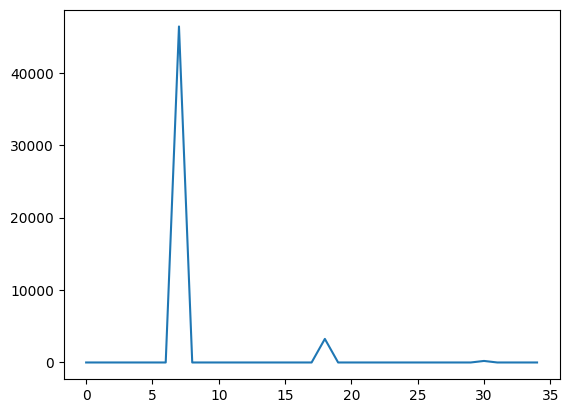

In [206]:
plt.plot(_Orbit.power_threshed[:35])

In [143]:
outlier_simul_one = (_Orbit.df['Residual']**2).tolist()
sorted_data = sorted(outlier_simul_one,reverse=True)
index = int(len(sorted_data) * 0.05)
threshold = sorted_data[index]
outlier_simul_one = list(map(lambda x: -1 if x > threshold else 1,outlier_simul_one))

In [144]:
outlier_simul_one.count(1)

950

In [145]:
outlier_simul_one.count(-1)

50

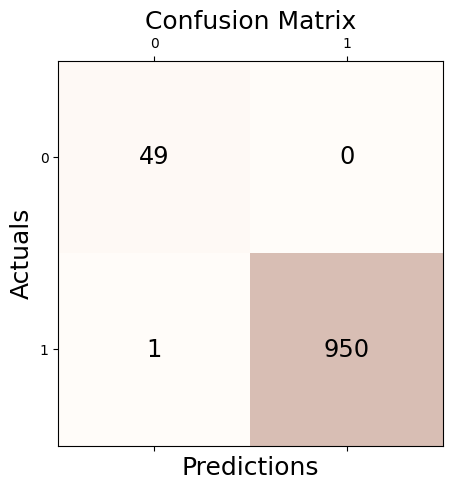

Accuracy: 0.999
Precision: 1.000
Recall: 0.999
F1 Score: 0.999


In [146]:
_conf = Conf_matrx(outlier_true_one,outlier_simul_one)
_conf.conf("GODE")

x축(FPR)

In [147]:
_conf.conf_matrix[0][0] / (_conf.conf_matrix[0][0] + _conf.conf_matrix[0][1])

1.0

y축(TPR)

In [148]:
_conf.conf_matrix[0][1] / (_conf.conf_matrix[0][0] + _conf.conf_matrix[0][1])

0.0

# Bunny

In [209]:
G = graphs.Bunny()
n = G.N
g = filters.Heat(G, tau=75) 
n=2503
np.random.seed(1212)
normal = np.around(np.random.normal(size=n),15)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2023-10-17 18:24:01,701:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [210]:
G.coords.shape
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]
_df1 = {'W':_W,'x':_x,'y':_y,'z':_z, 'fnoise':f+noise,'f' : f, 'noise': noise,'unif':unif}
_df = pd.DataFrame({'x': _df1['x'],'y':_df1['y'],'z':_df1['z'],'fnoise':_df1['fnoise'],'f':_df1['f'],'noise':_df1['noise']})
unif = _df1['unif']
outlier_true_one_2 = unif.copy()
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))
X = np.array(_df)[:,:4]

## GODE_Bunny

In [211]:
_W = _df1['W']
_BUNNY = BUNNY(_df)
_BUNNY.fit(sd=20,ref=10)
len(_BUNNY.f)

2503

In [217]:
pd.unique(_BUNNY.power_threshed)

array([3980.53117899, 2784.84426941, 2785.82506586,    0.        ,
        186.14028939])

In [221]:
_BUNNY.power_threshed[:10]

array([3980.53117899, 2784.84426941, 2785.82506586,    0.        ,
          0.        ,  186.14028939,    0.        ,    0.        ,
          0.        ,    0.        ])

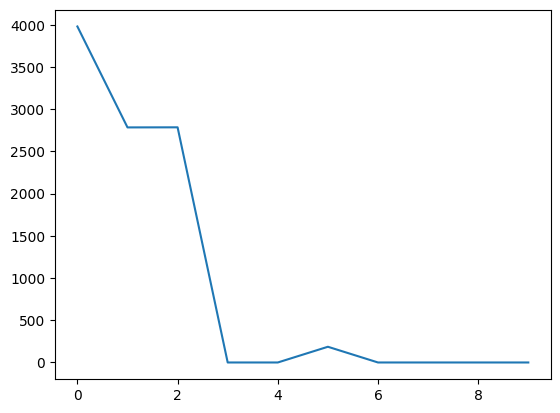

In [223]:
plt.plot(_BUNNY.power_threshed[:10])

In [213]:
2503*0.05

125.15

In [212]:
outlier_simul_one = (_BUNNY.df['Residual']**2).tolist()
sorted_data = sorted(outlier_simul_one,reverse=True)
index = int(len(sorted_data) * 0.05)
threshold = sorted_data[index]
outlier_simul_one = list(map(lambda x: -1 if x > threshold else 1,outlier_simul_one))

In [214]:
outlier_simul_one.count(1)

2378

In [215]:
outlier_simul_one.count(-1)

125

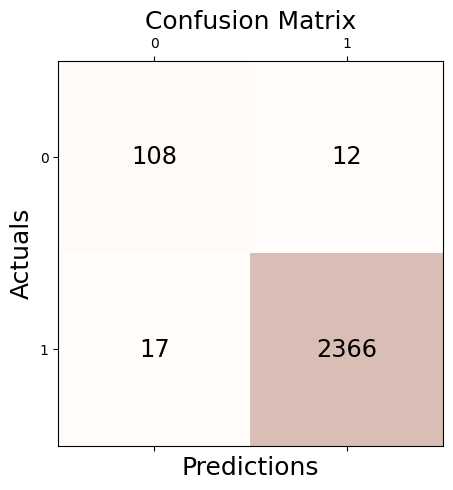

Accuracy: 0.988
Precision: 0.995
Recall: 0.993
F1 Score: 0.994


In [216]:
_conf = Conf_matrx(outlier_true_one_2,outlier_simul_one)
_conf.conf("GODE")